https://scikit-image.org/docs/stable/api/skimage.metrics.html

# Configuración de la arquitectura cuyos resultados se evalúan

Patch 128

Step '8 16 32 50 64 100 128'


Imágenes:

- 
Normalizadas en el rango [0,1]

- 
Interpoladas para que en HR tengan dimensiones (206, 244, 198)

Cantidad: 8

Shape en LR: (103, 122, 99)

WEIGHTS generados durante la EPOCH 215 (los que mejor resultado dan)


# PSNR

El PSNR se expresa en decibeles (dB).

Cuanto mayor sea el valor del PSNR, mejor será la calidad de la imagen comparada con la imagen de referencia. Un valor más alto indica una menor pérdida de información.

Valores comunes de PSNR para imágenes de alta calidad suelen estar en el rango de 30-50 dB.

# SSIM

El SSIM es una métrica que oscila entre -1 y 1.

Un valor de SSIM cercano a 1 indica que las dos imágenes son muy similares en términos de estructura y contenido.

Un valor negativo indica que las imágenes son muy diferentes.

Un valor de SSIM alrededor de 0 sugiere que las imágenes son prácticamente no similares.

# IFC (Intensity-Based Correlation Coefficient) )

El IFC no tiene un rango específico, ya que es una medida de correlación de intensidades y no se normaliza como el PSNR o SSIM.

Cuanto más cercano a 1 sea el valor del IFC, mayor será la similitud entre las imágenes en términos de intensidades de píxeles.

Un valor negativo indica una falta de correlación entre las intensidades de píxeles de las imágenes.

# Índice DICE 

El Índice DICE es siendo una medida de la superposición entre dos conjuntos, en este caso, los conjuntos de píxeles segmentados y los píxeles de referencia.

Cuanto mayor sea el valor del índice DICE, mejor será la coincidencia o superposición entre las regiones segmentadas y las regiones de referencia.

El DICE score varía entre 0 y 1, donde 0 indica ninguna superposición y 1 indica una superposición perfecta

# Valor de PSNR, SSIM, IFC e Índice DICE con varios pares de imágenes

In [1]:
import nibabel as nib
import numpy as np
import math
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import os

# Ruta de las carpetas de imágenes HR, SR (incluyen las imágenes superresueltas y las segmentaciones generadas por el modelo) y segmentaciones originales
hr_folder = '/home/veronicabp/Dataset/ATLAS_2/P9/imagenes/img_HR/T1w_HR/'
sr_root_folder = '/home/veronicabp/Dataset/ATLAS_2/P9/imagenes/img_LR/T1w_LR/'
true_seg_folder = '/home/veronicabp/Dataset/ATLAS_2/P9/segmentaciones/img_HR/label_HR/'

# Inicializa listas para almacenar las métricas
psnr_values = {}
ssim_values = {}
ifc_values = {}
dice_values = {}

# Itera a través de los archivos HR en la carpeta
for hr_file in os.listdir(hr_folder):
    if hr_file.startswith('sub-r') and hr_file.endswith('.nii.gz'):
        # Obtener el nombre común sin extensión
        common_name = hr_file[:-10]  
        # Elimina '_N_T.nii.gz' con [:-11], '.nii.gz' con [:-7], '_normalizada.nii.gz' con [:-19]
        
        # Ruta de cada archivo HR, cada archivo segmentado correctamente y su correspondiente carpeta SR
        hr_path = os.path.join(hr_folder, hr_file)
        sr_folder = os.path.join(sr_root_folder, common_name)
        tseg_path = os.path.join(true_seg_folder, common_name[:-3]+'label-L_desc-T1lesion_mask_HR.nii.gz')
        
        # Verifica si existe la carpeta SR correspondiente
        if os.path.exists(sr_folder):
            # Inicializa diccionarios para cada sr_file
            psnr_values[common_name] = {}
            ssim_values[common_name] = {}
            ifc_values[common_name] = {}
            dice_values[common_name] = {}
           
            # Carpetas que comienzan con "patch" que se deben buscar
            patch_folders = ["patch_128_step_8", "patch_128_step_16", "patch_128_step_32", "patch_128_step_50", 
                             "patch_128_step_64", "patch_128_step_100", "patch_128_step_128"] #Modificar para cada prueba
            
            # Realiza una búsqueda recursiva de carpetas "patch" dentro de la carpeta SR
            for root, dirs, files in os.walk(sr_folder):
                for patch_folder in patch_folders:
                    if patch_folder in dirs:
                        sr_path = os.path.join(root, patch_folder)
                        
                        # Encuentra el archivo SR que comienza con "SR_patch"
                        sr_file = next((f for f in os.listdir(sr_path) if f.startswith("SR_patch")), None)
                        
                        if sr_file:
                            sr_file_path = os.path.join(sr_path, sr_file)
                            
                            # Cargar las imágenes HR y SR (superresueltas)
                            nii_img_hr = nib.load(hr_path)
                            nii_img_sr = nib.load(sr_file_path)
                            
                            # Obtener los datos de las imágenes en forma de arreglos numpy
                            img_data_hr = nii_img_hr.get_fdata()
                            img_data_sr = nii_img_sr.get_fdata()
                            
                            # Calcular el PSNR
                            psnr = peak_signal_noise_ratio(img_data_hr, img_data_sr)
                            psnr_values[common_name][patch_folder] = psnr
                            
                            # Calcular el SSIM
                            ssim = structural_similarity(img_data_hr, img_data_sr)
                            ssim_values[common_name][patch_folder] = ssim
                            
                            # Calcular el IFC
                            mean_hr = np.mean(img_data_hr)
                            mean_sr = np.mean(img_data_sr)
                            std_hr = np.std(img_data_hr)
                            std_sr = np.std(img_data_sr)
                            
                            ifc = np.mean((img_data_hr - mean_hr) * (img_data_sr - mean_sr)) / (std_hr * std_sr)
                            ifc_values[common_name][patch_folder] = ifc
                        else:
                            print(f"¡Error! No se encontró un archivo SR válido en la carpeta '{patch_folder}' para '{common_name}'")
                        
                        # Encuentra el archivo label que comienza con "Cortex"
                        label_file = next((f for f in os.listdir(sr_path) if f.startswith("Cortex")), None)
                        
                        if label_file:
                            label_file_path = os.path.join(sr_path, label_file)
                            
                            # Cargar las imágenes segmentadas originales y producidas por el modelo
                            nii_true_seg = nib.load(tseg_path)
                            nii_label = nib.load(label_file_path)
                            
                            # Obtener los datos de las imágenes en forma de arreglos numpy
                            img_data_tseg = nii_true_seg.get_fdata()
                            img_data_label = nii_label.get_fdata()
                            
                            # Asegurarse de que las imágenes tengan la misma forma
                            assert img_data_tseg.shape == img_data_label.shape, "Las dimensiones de las imágenes no coinciden"
                            # Calcular el índice DICE
                            intersection = np.sum(img_data_tseg * img_data_label)
                            union = np.sum(img_data_tseg) + np.sum(img_data_label)
                            dice_index = (2.0 * intersection) / union
                            dice_values[common_name][patch_folder] = dice_index

                        else:
                            print(f"¡Error! No se encontró un archivo LABEL válido en la carpeta '{patch_folder}' para '{common_name}'")
        else:
            print(f"¡Error! No se encontró una carpeta SR correspondiente para '{common_name}'")

## Imprimir la media de las métricas 

In [2]:
# Inicializa un diccionario para almacenar las medias
psnr_means = {
    'patch_128_step_8': [],
    'patch_128_step_16': [],
    'patch_128_step_32': [],
    'patch_128_step_50': [],
    'patch_128_step_64': [],
    'patch_128_step_100': [],
    'patch_128_step_128': []
}

# Itera a través de los valores en psnr_values y agrega cada valor a la lista correspondiente en psrn_means
for values in psnr_values.values():
    for patch_type, psnr_value in values.items():
        psnr_means[patch_type].append(psnr_value)

# Calcula las medias para cada tipo de patch
for patch_type, psnr_values_list in psnr_means.items():
    if psnr_values_list:
        mean_psnr = sum(psnr_values_list) / len(psnr_values_list)
        psnr_means[patch_type] = mean_psnr

#print(psnr_means)

In [3]:
# Inicializa un diccionario para almacenar las medias
ssim_means = {
    'patch_128_step_8': [],
    'patch_128_step_16': [],
    'patch_128_step_32': [],
    'patch_128_step_50': [],
    'patch_128_step_64': [],
    'patch_128_step_100': [],
    'patch_128_step_128': []
}

# Itera a través de los valores en ssim_values y agrega cada valor a la lista correspondiente en ssim_means
for values in ssim_values.values():
    for patch_type, ssim_value in values.items():
        ssim_means[patch_type].append(ssim_value)

# Calcula las medias para cada tipo de patch
for patch_type, ssim_values_list in ssim_means.items():
    if ssim_values_list:
        mean_ssim = sum(ssim_values_list) / len(ssim_values_list)
        ssim_means[patch_type] = mean_ssim

#print(ssim_means)

In [4]:
# Inicializa un diccionario para almacenar las medias
ifc_means = {
    'patch_128_step_8': [],
    'patch_128_step_16': [],
    'patch_128_step_32': [],
    'patch_128_step_50': [],
    'patch_128_step_64': [],
    'patch_128_step_100': [],
    'patch_128_step_128': []
}

# Itera a través de los valores en ifc_values y agrega cada valor a la lista correspondiente en ifc_means
for values in ifc_values.values():
    for patch_type, ifc_value in values.items():
        ifc_means[patch_type].append(ifc_value)

# Calcula las medias para cada tipo de patch
for patch_type, ifc_values_list in ifc_means.items():
    if ifc_values_list:
        mean_ifc = sum(ifc_values_list) / len(ifc_values_list)
        ifc_means[patch_type] = mean_ifc

#print(ifc_means)

In [5]:
# Inicializa un diccionario para almacenar las medias
dice_means = {
    'patch_128_step_8': [],
    'patch_128_step_16': [],
    'patch_128_step_32': [],
    'patch_128_step_50': [],
    'patch_128_step_64': [],
    'patch_128_step_100': [],
    'patch_128_step_128': []
}

# Itera a través de los valores en dice_values y agrega cada valor a la lista correspondiente en dice_means
for values in dice_values.values():
    for patch_type, dice_value in values.items():
        dice_means[patch_type].append(dice_value)

# Calcula las medias para cada tipo de patch
for patch_type, dice_values_list in dice_means.items():
    if dice_values_list:
        mean_dice = sum(dice_values_list) / len(dice_values_list)
        dice_means[patch_type] = mean_dice

#print(dice_means)

In [6]:
# Lista de tipos de configuración
conf_types = ['patch_128_step_8', 'patch_128_step_16', 'patch_128_step_32', 'patch_128_step_50', 
              'patch_128_step_64', 'patch_128_step_100', 'patch_128_step_128']

# Itera a través de los tipos de configuración
for conf_type in conf_types:
    print(f"Tipo de configuración: {conf_type}")
    print(f"Media de PSNR: {psnr_means[conf_type]}")
    print(f"Media de SSIM: {ssim_means[conf_type]}")
    print(f"Media de IFC: {ifc_means[conf_type]}")
    print(f"Media de Índice DICE: {dice_means[conf_type]}")
    print()

print() 
print(f"MEDIA TOTAL: PATCH 128")
print(f"PSNR: {(psnr_means['patch_128_step_8']+psnr_means['patch_128_step_16']+psnr_means['patch_128_step_32']+psnr_means['patch_128_step_50']+psnr_means['patch_128_step_64']+psnr_means['patch_128_step_128']+psnr_means['patch_128_step_100'])/7}")
print(f"SSIM: {(ssim_means['patch_128_step_8']+ssim_means['patch_128_step_16']+ssim_means['patch_128_step_32']+ssim_means['patch_128_step_50']+ssim_means['patch_128_step_64']+ssim_means['patch_128_step_128']+ssim_means['patch_128_step_100'])/7}")
print(f"IFC: {(ifc_means['patch_128_step_8']+ifc_means['patch_128_step_16']+ifc_means['patch_128_step_32']+ifc_means['patch_128_step_50']+ifc_means['patch_128_step_64']+ifc_means['patch_128_step_128']+ifc_means['patch_128_step_100'])/7}")
print(f"Índice DICE: {(dice_means['patch_128_step_8']+dice_means['patch_128_step_16']+dice_means['patch_128_step_32']+dice_means['patch_128_step_50']+dice_means['patch_128_step_64']+dice_means['patch_128_step_128']+dice_means['patch_128_step_100'])/7}")

Tipo de configuración: patch_128_step_8
Media de PSNR: 31.142501776688658
Media de SSIM: 0.9547339780559135
Media de IFC: 0.9656371514134914
Media de Índice DICE: 0.22358303983655772

Tipo de configuración: patch_128_step_16
Media de PSNR: 31.14263576317031
Media de SSIM: 0.9547341605659833
Media de IFC: 0.9656369377063252
Media de Índice DICE: 0.22373061690367135

Tipo de configuración: patch_128_step_32
Media de PSNR: 31.14245777398074
Media de SSIM: 0.9547323388347458
Media de IFC: 0.9656331763959135
Media de Índice DICE: 0.22228799798798962

Tipo de configuración: patch_128_step_50
Media de PSNR: 31.142641558264604
Media de SSIM: 0.9547333197641608
Media de IFC: 0.9656361138518155
Media de Índice DICE: 0.22387852255544932

Tipo de configuración: patch_128_step_64
Media de PSNR: 31.142690048288824
Media de SSIM: 0.9547300115131989
Media de IFC: 0.9656331146207628
Media de Índice DICE: 0.23098654484237535

Tipo de configuración: patch_128_step_100
Media de PSNR: 31.141931911386422
Me

# Gráficos evaluativos

## Reestructuración de los diccionarios donde se almacenan los datos a graficar

In [7]:
# Crear un diccionario para reordenar los valores de PSNR
psnr = {}
ssim = {}
ifc = {}
dice = {}

# Definición de los valores de "patch" y "step" que se desean incluir en el nuevo diccionario
patch_values = ["patch_128"]
step_values = ["step_8", "step_16", "step_32", "step_50", "step_64", "step_100", "step_128"]

# Iteración a través de los valores de "patch" y "step"
for patch in patch_values:
    psnr[patch] = {}
    for step in step_values:
        values = []
        for common_name, data in psnr_values.items():
            if f"{patch}_{step}" in data:
                values.append(data[f"{patch}_{step}"])
        psnr[patch][step] = values
        
for patch in patch_values:
    ssim[patch] = {}
    for step in step_values:
        values = []
        for common_name, data in ssim_values.items():
            if f"{patch}_{step}" in data:
                values.append(data[f"{patch}_{step}"])
        ssim[patch][step] = values

for patch in patch_values:
    ifc[patch] = {}
    for step in step_values:
        values = []
        for common_name, data in ifc_values.items():
            if f"{patch}_{step}" in data:
                values.append(data[f"{patch}_{step}"])
        ifc[patch][step] = values
        
for patch in patch_values:
    dice[patch] = {}
    for step in step_values:
        values = []
        for common_name, data in dice_values.items():
            if f"{patch}_{step}" in data:
                values.append(data[f"{patch}_{step}"])
        dice[patch][step] = values

In [8]:
print(psnr)

{'patch_128': {'step_8': [31.074976459175723, 30.390967343131116, 34.20710663399842, 29.892848116408985, 32.53934355089, 30.090309311307422, 30.45688324104228, 30.487579557555318], 'step_16': [31.074589210099006, 30.391209058481085, 34.20733167519829, 29.893060228558394, 32.53952038633191, 30.090600694860804, 30.456888362525596, 30.4878864893074], 'step_32': [31.074355388931025, 30.391252927623768, 34.206984788764984, 29.893176698341605, 32.539647681278, 30.090180316823194, 30.456684889140174, 30.487379500943174], 'step_50': [31.074503203077946, 30.39128720131218, 34.20789277736645, 29.892940514267664, 32.53990900762286, 30.090313802875023, 30.456751990544735, 30.48753396904996], 'step_64': [31.074868858076684, 30.391242131105397, 34.20848493645381, 29.89317022487699, 32.53958212797775, 30.090129409890203, 30.456224020948262, 30.487818676981483], 'step_100': [31.074585051757083, 30.390330979394207, 34.20628113627482, 29.892324903453176, 32.53925104113938, 30.089197371742486, 30.4559733

In [10]:
# Modificar los nombres de las claves en el diccionario psnr
for patch in psnr.keys():
    new_patch = patch.replace("patch_", "patch = ")
    psnr[new_patch] = psnr.pop(patch)

# Modificar los nombres de las claves en el diccionario ssim
for patch in ssim.keys():
    new_patch = patch.replace("patch_", "patch = ")
    ssim[new_patch] = ssim.pop(patch)

# Modificar los nombres de las claves en el diccionario ifc
for patch in ifc.keys():
    new_patch = patch.replace("patch_", "patch = ")
    ifc[new_patch] = ifc.pop(patch)
    
# Modificar los nombres de las claves en el diccionario dice
for patch in dice.keys():
    new_patch = patch.replace("patch_", "patch = ")
    dice[new_patch] = dice.pop(patch)

# Modificar los nombres de las claves en los diccionarios de step
for dictionary in [psnr, ssim, ifc, dice]:
    for patch, values in dictionary.items():
        for step in values.keys():
            new_step = step.replace('step_', '')
            values[new_step] = values.pop(step)

print(psnr)
print(ssim)
#print(ifc)
#print(dice)

{'patch = 128': {'100': [31.074585051757083, 30.390330979394207, 34.20628113627482, 29.892324903453176, 32.53925104113938, 30.089197371742486, 30.455973359666327, 30.487511447663866], '128': [31.074492716831024, 30.39048239207125, 34.207387312897765, 29.8920374668785, 32.53773224598697, 30.0887159999164, 30.454858306417655, 30.48738566602411], '8': [31.074976459175723, 30.390967343131116, 34.20710663399842, 29.892848116408985, 32.53934355089, 30.090309311307422, 30.45688324104228, 30.487579557555318], '16': [31.074589210099006, 30.391209058481085, 34.20733167519829, 29.893060228558394, 32.53952038633191, 30.090600694860804, 30.456888362525596, 30.4878864893074], '32': [31.074355388931025, 30.391252927623768, 34.206984788764984, 29.893176698341605, 32.539647681278, 30.090180316823194, 30.456684889140174, 30.487379500943174], '50': [31.074503203077946, 30.39128720131218, 34.20789277736645, 29.892940514267664, 32.53990900762286, 30.090313802875023, 30.456751990544735, 30.48753396904996], 

In [11]:
# Convertir las claves de los diccionarios a números enteros
def convert_keys_to_int(dictionary):
    new_dict = {}
    for key, value in dictionary.items():
        if isinstance(key, str) and key.isdigit():
            new_dict[int(key)] = value
        else:
            new_dict[key] = value
    return new_dict

# Aplicar la función a los diccionarios psnr, ssim e ifc
psnr = {patch: convert_keys_to_int(values) for patch, values in psnr.items()}
ssim = {patch: convert_keys_to_int(values) for patch, values in ssim.items()}
ifc = {patch: convert_keys_to_int(values) for patch, values in ifc.items()}
dice = {patch: convert_keys_to_int(values) for patch, values in dice.items()}

# Los diccionarios psnr, ssim e ifc ahora tienen las claves con números enteros
#print(psnr)
#print(ssim)
#print(ifc)
#print(dice)

## Gráfica de todos los datos ya estructurados

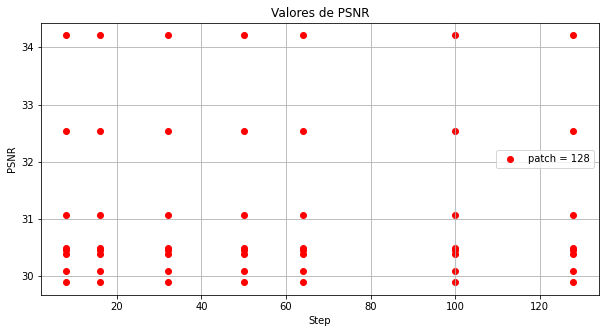

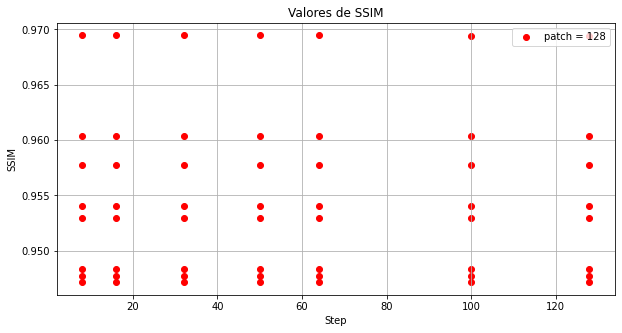

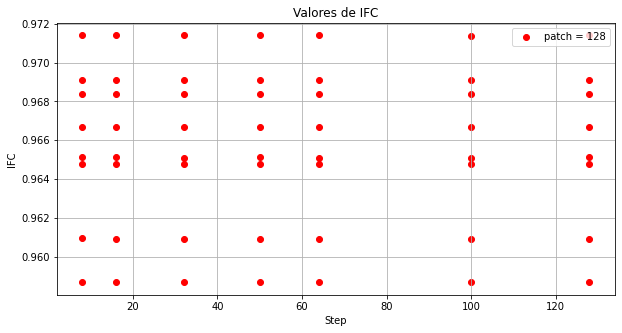

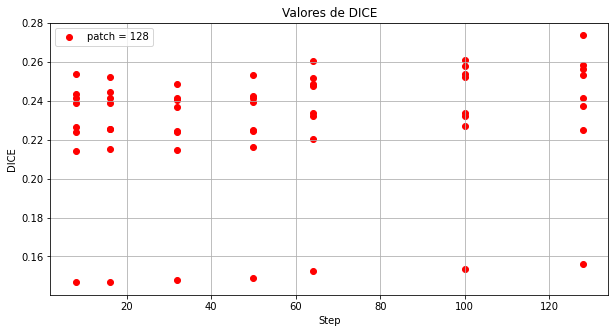

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Colores para patch_64 y patch_128
colors = {'patch = 128': 'red'}

# Métricas a graficar
metrics = ['PSNR', 'SSIM', 'IFC', 'DICE']
metric_data = [psnr, ssim, ifc, dice]

# Crear una gráfica para cada métrica
for metric, metric_dict in zip(metrics, metric_data):
    plt.figure(figsize=(10, 5))
    plt.title(f'Valores de {metric}')
    
    legend = {}  # Para controlar la leyenda
    
    for patch, step_data in metric_dict.items():
        for step, values in step_data.items():
            if values:
                x = [step] * len(values)
                y = values
                if patch not in legend:
                    plt.scatter(x, y, label=f'{patch}', color=colors[patch])
                    legend[patch] = True
                else:
                    plt.scatter(x, y, color=colors[patch])

    plt.xlabel('Step')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()



## Gráfica de la media de los datos (1 gráfica para cada valor de patch)

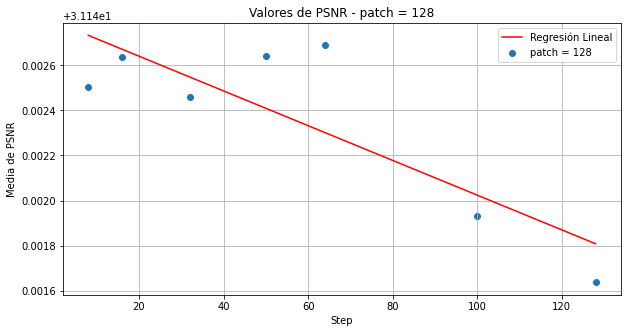

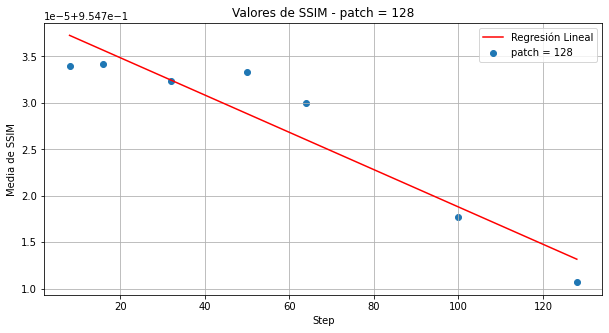

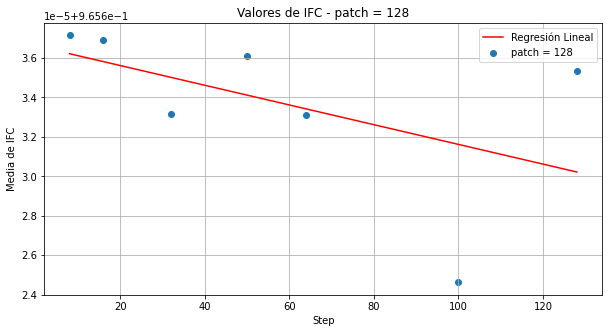

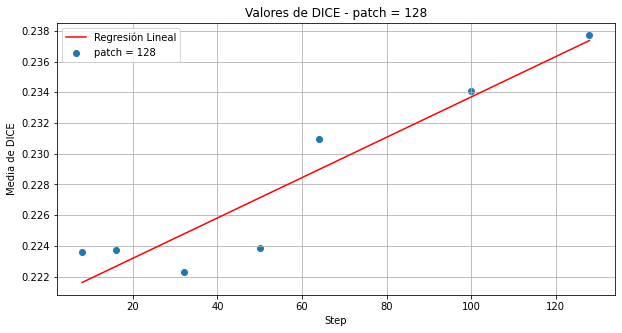

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Métricas a graficar
metrics = ['PSNR', 'SSIM', 'IFC', 'DICE']
metric_data = [psnr, ssim, ifc, dice]

for metric, metric_dict in zip(metrics, metric_data):
    for patch, step_data in metric_dict.items():
        if step_data:
            x_values = []  # Lista para almacenar los valores de x
            y_values = []  # Lista para almacenar las medias de y
            
            plt.figure(figsize=(10, 5))
            plt.title(f'Valores de {metric} - {patch}')
            
            for step, values in step_data.items():
                if values:
                    x_values.append(step)
                    y_values.append(np.mean(values))
                    
            


            plt.scatter(x_values, y_values, label=f'{patch}')
            
            # Calcular la regresión lineal
            coefficients = np.polyfit(x_values, y_values, 1)  # 1 indica una regresión lineal
            regression_line = np.poly1d(coefficients)
            x_regression = np.linspace(min(x_values), max(x_values), 100)
            y_regression = regression_line(x_regression)
            
            # Trazar la línea de regresión lineal
            plt.plot(x_regression, y_regression, label='Regresión Lineal', color='red')
            
            plt.xlabel('Step')
            plt.ylabel(f'Media de {metric}')
            plt.legend()
            plt.grid(True)

            plt.show()
